In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Layer

from tensorflow.keras.optimizers import Adam

# Prepare Data

In [2]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip "/content/celeba-dataset.zip" -d "/content/dataset/"

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/celeba-dataset.zip
replace /content/dataset/img_align_celeba/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N


In [3]:
  BATCH_SIZE = 128
  IM_SHAPE = (64,64,3)
  LEARNING_RATE = 2e-4
  LATENT_DIM = 100

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/img_align_celeba/img_align_celeba",
    label_mode = None,
    image_size = (IM_SHAPE[0], IM_SHAPE[1]),
                 batch_size = 32)


Found 202599 files.


In [5]:
dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [6]:
def preprocess(image):
  return tf.cast(image, tf.float32) / 127.5 -1.0

In [7]:
train_dataset = (
    dataset.
    map(preprocess)
    .unbatch()
    .shuffle(buffer_size =  1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE, drop_remainder = True)
    .prefetch(tf.data.AUTOTUNE)
)

In [8]:
for d in train_dataset.take(1):
  print(d.shape)

(128, 64, 64, 3)


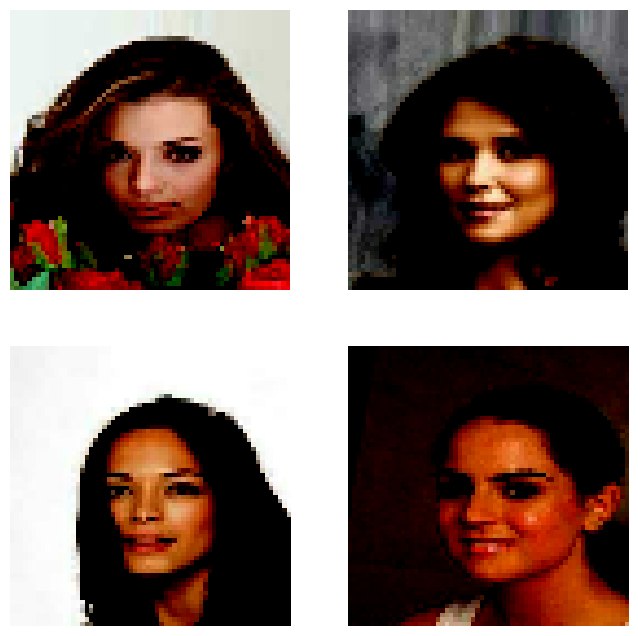

In [9]:
plt.figure(figsize =(8,8))
k = 0
n = 4
for i in range(n):
  ax = plt.subplot(2,2,k+1)
  plt.imshow(d[i])
  plt.axis("off")
  k+=1



# Modeling

In [10]:
generator = tf.keras.Sequential([
    Input(shape=(LATENT_DIM,)),
    Dense(4 * 4 * LATENT_DIM),
    Reshape((4, 4, LATENT_DIM)),

    Conv2DTranspose(512, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    # LeakyReLU(0.2),

    Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    # LeakyReLU(0.2),

    Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    # LeakyReLU(0.2),

    Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    # LeakyReLU(0.2),

    # Final layer to output an image with 3 channels (RGB) and 64x64 size
    Conv2DTranspose(3, kernel_size=4, strides=1, padding='same', activation='tanh'),
], name="generator")


In [11]:
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1600)                │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 512)           │         819,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 256)         │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 64, 64, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 64, 64, 3)           │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,741,187 (14.27 MB)

 Trainable params: 3,739,267 (14.26 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [12]:
# Check the shape of the generated image
random_latent_vector = tf.random.normal(shape=(1, LATENT_DIM))
generated_image = generator(random_latent_vector)
print(generated_image.shape)

(1, 64, 64, 3)


In [13]:
discriminator = tf.keras.Sequential([
    Input(shape=(IM_SHAPE[0],IM_SHAPE[1],3)),

    Conv2D(64, kernel_size=4, strides=2, padding="same", activation="relu"),
    # LeakyReLU(0.2),

    Conv2D(128, kernel_size=4, strides=2, padding="same", activation="relu"),
    BatchNormalization(),
    # LeakyReLU(0.2),

    Conv2D(256, kernel_size=4, strides=2, padding="same", activation="relu"),
    BatchNormalization(),
    # LeakyReLU(0.2),

    Conv2D(1, kernel_size=4, strides=2, padding ="same", activation="relu"),

    Flatten(),
    Dense(1, activation = "sigmoid")


], name="discriminator")


In [14]:
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 1)             │           4,097 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 664,530 (2.53 MB)

 Trainable params: 663,762 (2.53 MB)

 Non-trainable params: 768 (3.00 KB)

In [15]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @tf.function
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # Generate random latent vectors
        random_latent_vectors = tf.random.normal(shape=(batch_size, LATENT_DIM))

        # Generate fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine real and fake images
        combined_images = tf.concat([real_images, generated_images], axis=0)

        # Create labels for real (1) and fake (0) images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Generate misleading labels for the generator (all ones)
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator (note that we don't update the discriminator's weights here)
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors)
            predictions = self.discriminator(generated_images)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}


In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt

EPOCHS = 25

def train_gan(gan, dataset, epochs, latent_dim):
    # Create and pass the ShowImage callback when calling gan.fit
    show_image_callback = ShowImage(latent_dim)

    gan.fit(
        dataset,
        epochs=epochs,
        callbacks=[show_image_callback]
    )

# Create and compile the GAN
gan = GAN(discriminator, generator)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy()
)

# Train the GAN
train_gan(gan, train_dataset.take(100), 25, LATENT_DIM)


Epoch 1/25
    100/Unknown 44s 209ms/step - d_loss: 0.5666 - g_loss: 0.6549

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 238ms/step - d_loss: 0.5676 - g_loss: 0.6557
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 64s 234ms/step - d_loss: 0.6773 - g_loss: 0.6749
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 241ms/step - d_loss: 0.6900 - g_loss: 0.6913
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 227ms/step - d_loss: 0.6933 - g_loss: 0.6988
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - d_loss: 0.6932 - g_loss: 0.6941
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 226ms/step - d_loss: 0.6930 - g_loss: 0.6904
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 224ms/step - d_loss: 0.6928 - g_loss: 0.6861
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 224ms/step - d_loss: 0.6927 - g_loss: 0.6821
Epoch 9/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 222ms/step - d_loss: 0.6925 - g_loss: 0.6781
Epoch 10/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - d_loss: 0.6924 - g_loss: 0.6744
Epoch 11/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 223ms/step - d_loss: 0.6923 - g_loss: 0.6708
Epoch 12/25
100/100 ━━━━━━━━━━

In [17]:
class ShowImage(tf.keras.callbacks.Callback):
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        n = 6  # Number of images to display per row/column
        k = 0
        random_latent_vectors = tf.random.normal(shape=(n * n, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)  # No need to set `self.model`, Keras does it for you

        plt.figure(figsize=(16, 16))
        for i in range(n):
            for j in range(n):
                ax = plt.subplot(n, n, k + 1)
                plt.imshow((generated_images[k] + 1) / 2)  # Rescale to [0, 1]
                plt.axis("off")
                k += 1

        plt.savefig(f"generated/gen_images_epoch_{epoch}.png")
        plt.close()


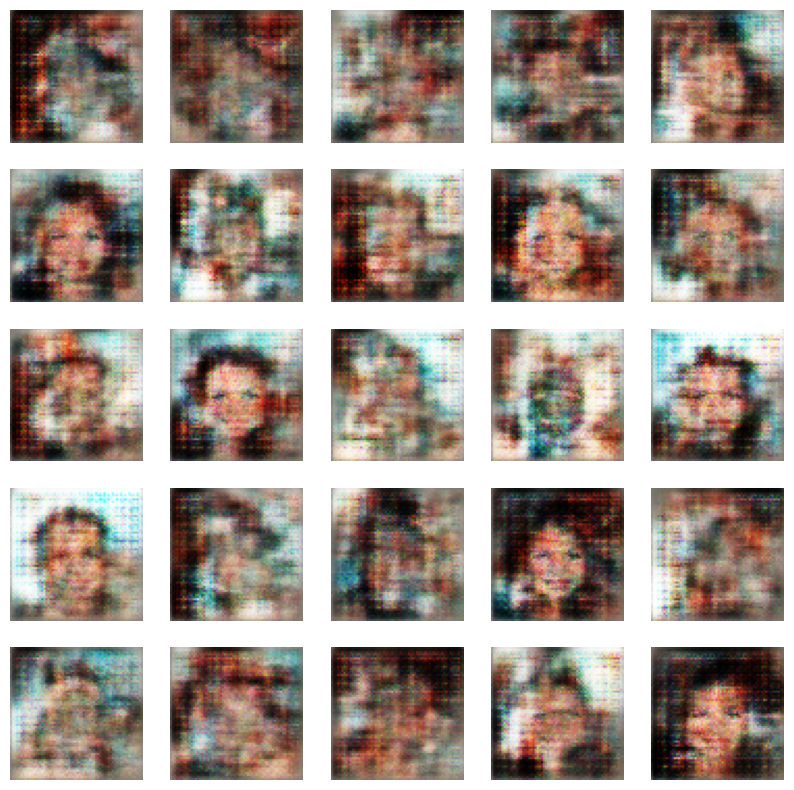

In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt

def evaluate_gan(gan, latent_dim, num_samples=25):
    """Generate and display images from the generator to evaluate the GAN."""
    # Generate random latent vectors (input noise)
    random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))

    # Use the generator to create images
    generated_images = gan.generator(random_latent_vectors)

    # Rescale generated images to [0, 1] for visualization
    generated_images = (generated_images + 1) / 2

    # Plot the generated images in a grid
    n = int(num_samples ** 0.5)  # Assuming the number of samples is a perfect square
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(n, n, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

# Evaluate the GAN after training
evaluate_gan(gan, LATENT_DIM, num_samples=25)


In [22]:
import matplotlib.pyplot as plt

# Assuming you have stored the losses during training
d_losses = []  # Store discriminator losses
g_losses = []  # Store generator losses

def train_gan(gan, dataset, epochs, latent_dim):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for real_images in dataset:
            d_loss, g_loss = gan.train_step(real_images)
            d_losses.append(d_loss)
            g_losses.append(g_loss)

    # Plot loss curves
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.title('Loss Curves')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
